### 一、环境准备

**构建SQL查询** 使用自然语言进行SQL查询

**使用Langchain了解数据库相关信息** Query a SQL database using chains for query creation and execution

**使用自然语言进行复杂的SQL查询** Interact with a SQL database using agents for robust and flexible querying


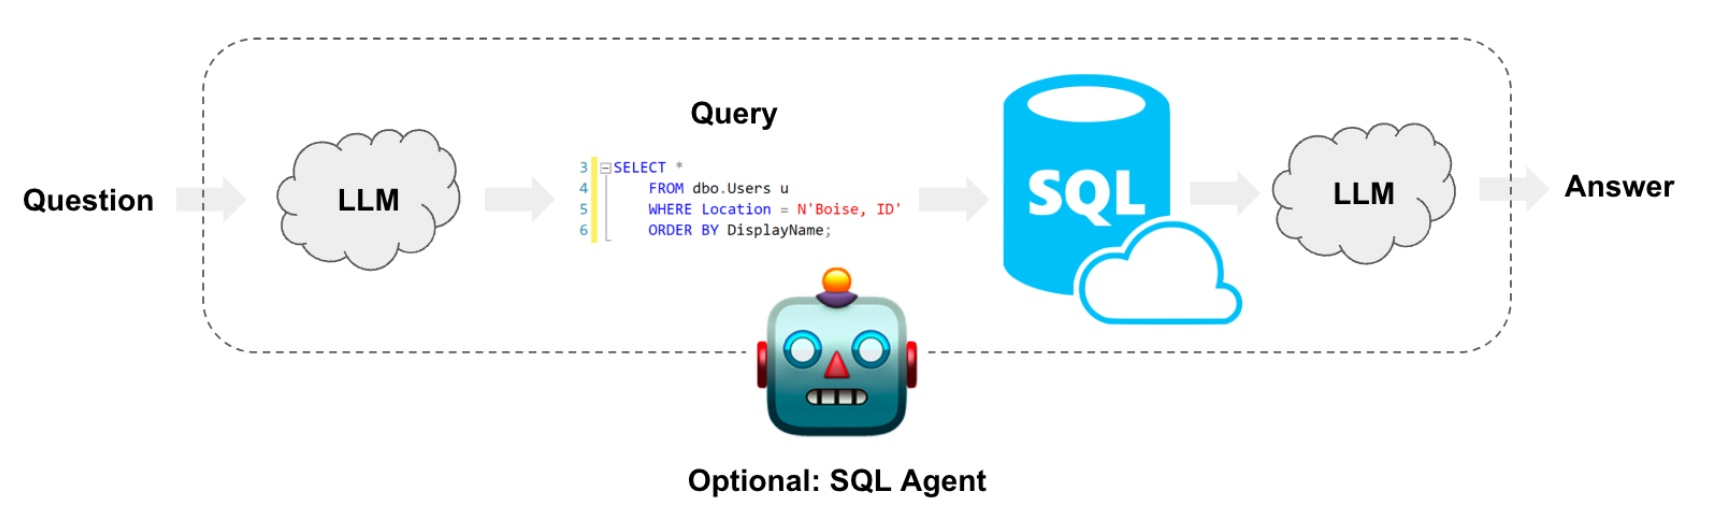

In [ ]:
!pip install langchain langchain-experimental openai
##  需要在环境变量里准备OPENAI_API_KEY

创建 Chinook.db 在这个nootbook的子目录InteractingwithSQL:

- Save [link this file](https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql) to the directory as Chinook_Sqlite.sql

- Run sqlite3 Chinook.db

- Run .read Chinook_Sqlite.sql

- Test SELECT * FROM Artist LIMIT 10;

### 二、数据库信息描述和简单查询

In [4]:
# 创建数据库访问链接
from langchain.llms import OpenAI
from langchain.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain

db = SQLDatabase.from_uri("sqlite:///InteractingwithSQL//Chinook.db")
llm = OpenAI(temperature=0, verbose=True)
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [40]:
# 简单的数据查询
db_chain.run("这里有多少员工?")



> Entering new SQLDatabaseChain chain...
这里有多少员工?
SQLQuery:SELECT COUNT(*) FROM "Employee";
SQLResult: [(8,)]
Answer:There are 8 employees.
> Finished chain.


'There are 8 employees.'

In [ ]:
#介绍数据库的信息
db_chain.run("数据库里有哪些表")

In [ ]:
## 介绍表的信息
db_chain.run("描述一下Alibum表")

### 三、使用Agent进行数据库的复杂查询

In [13]:
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit

# from langchain.agents import AgentExecutor
from langchain.agents.agent_types import AgentType

db = SQLDatabase.from_uri("sqlite:///InteractingwithSQL//Chinook.db")

agent_executor = create_sql_agent(
    llm=OpenAI(temperature=0),
    toolkit=SQLDatabaseToolkit(db=db, llm=OpenAI(temperature=0)),
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
)

In [ ]:
agent_executor.run(
    "列出来销售最多的3个国家，每个国家有多销售"
)

In [ ]:
agent_executor.run(
    "介绍一下invoice这个表格"
)

### 四、增使用RAG进行SQL查询

In [32]:
few_shots = {
    "List all artists.": "SELECT * FROM artists;",
    "Find all albums for the artist 'AC/DC'.": "SELECT * FROM albums WHERE ArtistId = (SELECT ArtistId FROM artists WHERE Name = 'AC/DC');",
    "List all tracks in the 'Rock' genre.": "SELECT * FROM tracks WHERE GenreId = (SELECT GenreId FROM genres WHERE Name = 'Rock');",
    "Find the total duration of all tracks.": "SELECT SUM(Milliseconds) FROM tracks;",
    "List all customers from Canada.": "SELECT * FROM customers WHERE Country = 'Canada';",
    "How many tracks are there in the album with ID 5?": "SELECT COUNT(*) FROM tracks WHERE AlbumId = 5;",
    "Find the total number of invoices.": "SELECT COUNT(*) FROM invoices;",
    "List all tracks that are longer than 5 minutes.": "SELECT * FROM tracks WHERE Milliseconds > 300000;",
    "Who are the top 5 customers by total purchase?": "SELECT CustomerId, SUM(Total) AS TotalPurchase FROM invoices GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5;",
    "Which albums are from the year 2000?": "SELECT * FROM albums WHERE strftime('%Y', ReleaseDate) = '2000';",
    "How many employees are there": 'SELECT COUNT(*) FROM "Employee"',
}

In [33]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.schema import Document
from langchain.vectorstores import FAISS

embeddings = OpenAIEmbeddings()

few_shot_docs = [
    Document(page_content=question, metadata={"sql_query": few_shots[question]})
    for question in few_shots.keys()
]
vector_db = FAISS.from_documents(few_shot_docs, embeddings)
retriever = vector_db.as_retriever()

In [34]:
from langchain.agents.agent_toolkits import create_retriever_tool

tool_description = """
This tool will help you understand similar examples to adapt them to the user question.
Input to this tool should be the user question.
"""

retriever_tool = create_retriever_tool(
    retriever, name="sql_get_similar_examples", description=tool_description
)
custom_tool_list = [retriever_tool]

In [38]:
from langchain.agents import AgentType, create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.chat_models import ChatOpenAI
from langchain.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///InteractingwithSQL//Chinook.db")
llm = ChatOpenAI(model_name="gpt-4", temperature=0)

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

custom_suffix = """
I should first get the similar examples I know.
If the examples are enough to construct the query, I can build it.
Otherwise, I can then look at the tables in the database to see what I can query.
Then I should query the schema of the most relevant tables
"""

agent = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    extra_tools=custom_tool_list,
    suffix=custom_suffix,
)

In [39]:
agent.run("How many employees do we have?")



> Entering new AgentExecutor chain...

Invoking: `sql_get_similar_examples` with `{'query': 'How many employees do we have?'}`


[Document(page_content='How many employees are there', metadata={'sql_query': 'SELECT COUNT(*) FROM "Employee"'}), Document(page_content='Find the total number of invoices.', metadata={'sql_query': 'SELECT COUNT(*) FROM invoices;'}), Document(page_content='Who are the top 5 customers by total purchase?', metadata={'sql_query': 'SELECT CustomerId, SUM(Total) AS TotalPurchase FROM invoices GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5;'}), Document(page_content='List all customers from Canada.', metadata={'sql_query': "SELECT * FROM customers WHERE Country = 'Canada';"})]
Invoking: `sql_db_query_checker` with `SELECT COUNT(*) FROM "Employee"`
responded: Based on the similar examples, the query should be 'SELECT COUNT(*) FROM "Employee"'. But before executing it, I should check if the query is correct.

SELECT COUNT(*) FROM "Employee"
Invoking: `sql_

'We have 8 employees.'